In [1]:
import norm_heatmap
import normalize
import experiment_normalized_depth_loss
import tools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import heatmap_workflow_tools as hwt
import os

# 1. Pre-Processing

### 1.1. Adjust Variables as Necessary (input requried)

In [2]:
# In quotes, put paths to folders containing tiffs for SOI and Normalization signals, respectively
stack_dir = os.path.abspath("/Users/sathlerar/Documents/franco/hsp9056/Hsp90_3NT56/")
norm_dir = os.path.abspath("/Users/sathlerar/Documents/franco/hsp9056/DAPI/")

# Replace with slice integers or decimal percentages. 'None' for no boundary.
zmin, zmax = None, None

# how many microns is a single image/slice?
slice_depth = 0.79

# how many slices does a monolayer of your cell type represent?
monolayer_num_slices = 15

### 1.2. Variable Processing

In [3]:
stack_tiffs = tools.get_files(stack_dir)

In [4]:
norm_tiffs = tools.get_files(norm_dir)

In [5]:
zmin, zmax = hwt.process_zmin_zmax(zmin, zmax, stack_tiffs)
print(f"Processed ZMin and ZMax: {zmin}, {zmax}")

Processed ZMin and ZMax: 0, 64


In [6]:
stack_name = os.path.basename(stack_dir)
norm_name = os.path.basename(norm_dir)
base_dir = os.path.basename(os.path.dirname(norm_dir))
out_dir = os.path.abspath(os.path.join(os.path.abspath(''), '..', 'hmp_paper_data'))
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
out_dir = os.path.join(out_dir, f"{base_dir}_{stack_name}n{norm_name}_out")
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

# 2. Raw Heatmap

### 2.1. SOI MSI

In [ ]:
stack_means = np.array([])
stack_stds = np.array([])
for img in stack_tiffs[zmin:zmax]:
    mean, std = normalize.tiff_mean_std(img, 0, -1, True, 0)
    stack_means = np.append(stack_means, mean)
    stack_stds = np.append(stack_stds, std)
hwt.plot_MSI(stack_means, stack_stds, slice_depth,
             f"{base_dir} {stack_name} z{zmin}-{zmax} MSI",
             os.path.join(out_dir, f"{base_dir}_{stack_name}_z{zmin}-{zmax}_MSI.png"))

### 2.2. SOI MIP

In [ ]:
imgs = norm_heatmap.stack(stack_tiffs[zmin:zmax], ['z', 'x', 'y'], 20)

In [ ]:
hwt.plot_MIP(imgs, f"{base_dir} {stack_name} z{zmin}-{zmax}", os.path.join(out_dir, f"{base_dir}_{stack_name}_z{zmin}-{zmax}_MIP.png"))

# 3. Getting normalized heatmap

### 3.1. Norm MIP

In [ ]:
norm_means = np.array([])
norm_stds = np.array([])
for norm_tiff in norm_tiffs[zmin:zmax]:
    mean, std = normalize.tiff_mean_std(norm_tiff, 0, -1, True, 0)
    norm_means = np.append(norm_means, mean)
    norm_stds = np.append(norm_stds, std)
hwt.plot_MSI(norm_means, norm_stds, slice_depth,
             f"{base_dir} {norm_name} z{zmin}-{zmax} MSI",
             os.path.join(out_dir, f"{base_dir}_{norm_name}_z{zmin}-{zmax}_MSI.png"))

### 3.2. Normalized SOI MIP

In [ ]:
%%capture
norm_stack_tiffs = normalize.mean_normalizer(stack_tiffs, norm_tiffs, 0, -1, True, False)

In [ ]:
norm_stack_means = np.array([])
norm_stack_stds = np.array([])
for norm_stack_tiff in norm_stack_tiffs[zmin:zmax]:
    mean, std = normalize.tiff_mean_std(norm_stack_tiff, 0, -1, True, 0)
    norm_stack_means = np.append(norm_stack_means, mean)
    norm_stack_stds = np.append(norm_stack_stds, std)
hwt.plot_MSI(norm_stack_means, norm_stack_stds, slice_depth,
             f"{base_dir} {stack_name} norm {norm_name} z{zmin}-{zmax} MSI",
             os.path.join(out_dir, f"{base_dir}_{stack_name}n{norm_name}_z{zmin}-{zmax}_MSI.png"))

### 3.3. Normalized SOI MIP

In [ ]:
imgs = norm_heatmap.stack(norm_stack_tiffs[zmin:zmax], ['z', 'x', 'y'], 20)

In [ ]:
hwt.plot_MIP(imgs, f"{base_dir} {stack_name} norm {norm_name} z{zmin}-{zmax}", os.path.join(out_dir, f"{base_dir}_{stack_name}n{stack_name}_z{zmin}-{zmax}_MIP.png"))

# 4. Heatmap w/ Monolayer-Excluded (EM) Normalization

### 4.1 Tumoroid Boundary Detection

In [ ]:
#getting mask/boundary...
monolayer_percentage = monolayer_num_slices / len(norm_tiffs)
mask = normalize.get_norm_bool_idxs(norm_tiffs[zmin:zmax], monolayer_percentage)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
im = ax1.imshow(mask, cmap = 'magma')
plt.colorbar(im)
plt.title(f"{norm_name} EM Mask ({monolayer_num_slices} slices/{round(monolayer_num_slices * 100, 2)}%)")
plt.savefig(os.path.join(out_dir, f"{base_dir}_{norm_name}_EM_Mask.png"))

### 4.2 Monolayer-Excluded (EM) Norm MSI

In [ ]:
norm_means_EM = np.array([])
norm_stds_EM = np.array([])
for norm_tiff in norm_tiffs[zmin:zmax]:
    mean, std = normalize.tiff_mean_std(norm_tiff, 0, -1, True, mask)
    norm_means_EM = np.append(norm_means_EM, mean)
    norm_stds_EM = np.append(norm_stds_EM, std)
hwt.plot_MSI(norm_means_EM, norm_stds_EM, slice_depth,
             f"{base_dir} EM {norm_name} z{zmin}-{zmax} MSI",
             os.path.join(out_dir, f"{base_dir}_EM_{norm_name}_z{zmin}-{zmax}_`MSI.png"))


### 4.3 EM-Normalized SOI MSI

In [ ]:
%%capture
norm_stack_tiffs_EM = normalize.mean_normalizer(stack_tiffs, norm_tiffs, 0, -1, True, True)

In [ ]:
norm_stack_means_EM = np.array([])
norm_stack_stds_EM = np.array([])
for norm_stack_tiff_EM in norm_stack_tiffs_EM[zmin:zmax]:
    mean, std = normalize.tiff_mean_std(norm_stack_tiff_EM, 0, -1, True, 0)
    norm_stack_means_EM = np.append(norm_stack_means_EM, mean)
    norm_stack_stds_EM = np.append(norm_stack_stds_EM, std)
hwt.plot_MSI(norm_stack_means, norm_stack_stds, slice_depth,
             f"{base_dir} {stack_name} EM norm {norm_name} z{zmin}-{zmax} MSI",
             os.path.join(out_dir, f"{base_dir}_{stack_name}EMn{norm_name}_z{zmin}-{zmax}_MSI.png"))

### 4.4 EM-Normalized SOI MIP

In [ ]:
imgs = norm_heatmap.stack(norm_stack_tiffs_EM[zmin:zmax], ['z', 'x', 'y'], 20)

In [ ]:
hwt.plot_MIP(imgs, f"{base_dir} {stack_name} EM norm {norm_name} z{zmin}-{zmax}", os.path.join(out_dir, f"{base_dir}_{stack_name}EMn{stack_name}_z{zmin}-{zmax}_MIP.png"))

In [25]:
def percentage(arr):
    return arr / np.max(arr) * 100

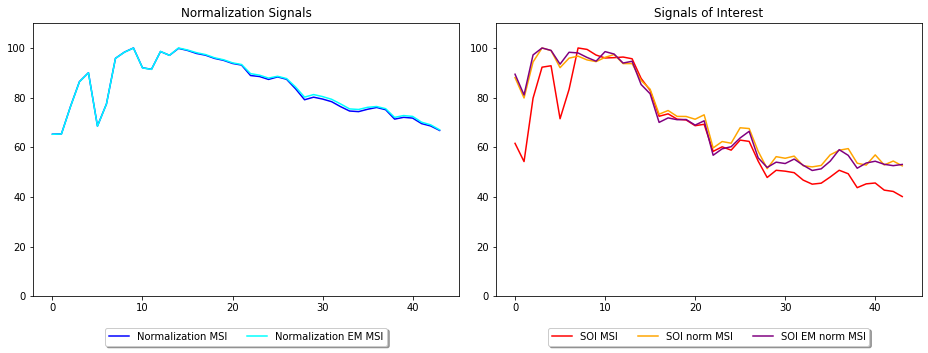

In [60]:
xvals = np.arange(0, len(stack_tiffs))
fig = plt.figure(figsize = (13, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(xvals, percentage(norm_means), label = "Normalization MSI", color = "blue")
ax1.plot(xvals, percentage(norm_means_EM), label = "Normalization EM MSI", color = "cyan")
# ax1.plot(xvals, percentage(norm_norm_means), label = "Normalization Stack Self-Normalized", color = "purple")
ax1.set_ylim((0, 110))
ax1.set_title("Normalization Signals")
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -.2),
           ncol=3, fancybox=True, shadow=True)
ax2.plot(xvals, percentage(stack_means), label = "SOI MSI", color = "red")
ax2.plot(xvals, percentage(norm_stack_means), label = "SOI norm MSI", color = "orange")
ax2.plot(xvals, percentage(norm_stack_means_EM), label = "SOI EM norm MSI", color = "purple")
ax2.set_ylim((0, 110))
ax2.set_title("Signals of Interest")
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -.2),
           ncol=3, fancybox=True, shadow=True)
plt.tight_layout()